# Import data
copying from wfdb website 
https://wfdb.readthedocs.io/en/latest/processing.html#module-3

In [1]:
# Libraries for interfacing with WFDB data
import wfdb
from wfdb import processing

#Libraries for detrending
import obspy as obs

#Classical libraries 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Files stuff to read from disk
path='physionet.org/files/fantasia/1.0.0/' # relative path to data files
files= np.loadtxt(path+'RECORDS', dtype='str') # name of all files (no extensions as required by wfdb functions)

In [3]:
# DataFrames to handle all signals (RAW ECG, RR intervals, Annotations, ...)
ECG_sig=pd.DataFrame(columns=files)

RR_intervals = pd.DataFrame(columns=files)

In [ ]:

# Read ECG data from files and store them in Pandas DataFrame
# Save fields too, for further optional analysis
signals_dfs=[]
rr_dfs=[]

for file in files:
    sig, fields =  wfdb.rdsamp(path + file, channels=[1]) # channel 1 maps to ECG data
    signals_dfs.append(pd.DataFrame({file: sig.T[0]}))
    
    xqrs = processing.XQRS(sig=sig[:,0], fs=fields['fs'])
    xqrs.detect()
    rr=processing.calc_rr(xqrs.qrs_inds, fs=fields['fs'])
    rr_dfs.append(pd.DataFrame({file: rr}))

ECG_sig=pd.concat(signals_dfs, ignore_index=True, axis=1)
ECG_sig.columns=files

RR_intervals=pd.concat(rr_dfs, ignore_index=True, axis=1)
RR_intervals.columns=files

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Learning initial signal parameters...
Found 8 beats during learn

In [61]:
#ECG_sig.to_hdf('ECG_sig.hdf', key='ECG_sig')
#RR_intervals.to_hdf('RR_intervals.hdf', key='RR_intervals')

In [127]:
RR_intervals=pd.read_hdf('RR_intervals.hdf')

In [131]:
B=pd.DataFrame()
B_df=[]
for file in files:
    B_df.append(pd.DataFrame({file:np.cumsum(RR_intervals[file])}))
B=pd.concat(B_df, axis=1, ignore_index=True)
B.columns=files

In [132]:
B.describe()

,f1o01,f1o02,f1o03,f1o04,f1o05,f1o06,f1o07,f1o08,f1o09,f1o10,...,f2y01,f2y02,f2y03,f2y04,f2y05,f2y06,f2y07,f2y08,f2y09,f2y10
count,7.171000e+03,6.822000e+03,7.228000e+03,6.243000e+03,5.734000e+03,6.230000e+03,7.149000e+03,8.494000e+03,4.925000e+03,8.240000e+03,...,0.0,6.573000e+03,6.807000e+03,8.606000e+03,0.0,6.850000e+03,6.505000e+03,0.0,0.0,0.0
mean,9.018726e+05,8.974631e+05,8.964609e+05,9.078093e+05,7.700540e+05,9.136209e+05,8.924737e+05,8.934666e+05,8.884353e+05,8.996322e+05,...,NaN,1.178064e+06,8.800581e+05,8.728236e+05,NaN,8.597733e+05,8.746946e+05,NaN,NaN,NaN
std,5.265868e+05,5.258887e+05,5.245596e+05,5.238478e+05,4.508341e+05,5.254329e+05,5.228896e+05,5.257542e+05,5.241887e+05,5.257080e+05,...,NaN,6.816887e+05,5.068433e+05,5.107582e+05,NaN,5.059492e+05,5.054863e+05,NaN,NaN,NaN
min,2.490000e+02,2.410000e+02,1.960000e+02,3.090000e+02,2.530000e+02,3.120000e+02,2.480000e+02,1.860000e+02,3.680000e+02,2.270000e+02,...,NaN,3.080000e+02,2.570000e+02,1.890000e+02,NaN,2.350000e+02,2.440000e+02,NaN,NaN,NaN
25%,4.440005e+05,4.394672e+05,4.396380e+05,4.528835e+05,3.774645e+05,4.591030e+05,4.382600e+05,4.333325e+05,4.353480e+05,4.419185e+05,...,NaN,5.844750e+05,4.460005e+05,4.282852e+05,NaN,4.216348e+05,4.414220e+05,NaN,NaN,NaN
50%,8.978000e+05,8.940430e+05,8.908820e+05,9.089220e+05,7.645460e+05,9.144125e+05,8.852410e+05,8.913200e+05,8.750470e+05,8.950025e+05,...,NaN,1.176250e+06,8.783330e+05,8.688870e+05,NaN,8.475820e+05,8.736780e+05,NaN,NaN,NaN
75%,1.359224e+06,1.354936e+06,1.349282e+06,1.364335e+06,1.159986e+06,1.369872e+06,1.345442e+06,1.349046e+06,1.341572e+06,1.356260e+06,...,NaN,1.779681e+06,1.318464e+06,1.316170e+06,NaN,1.296685e+06,1.310350e+06,NaN,NaN,NaN
max,1.812551e+06,1.810839e+06,1.813246e+06,1.810853e+06,1.558083e+06,1.819463e+06,1.808975e+06,1.802651e+06,1.809889e+06,1.813193e+06,...,NaN,2.342206e+06,1.758381e+06,1.763601e+06,NaN,1.755206e+06,1.753793e+06,NaN,NaN,NaN


In [100]:
def B(b, m, start=0):
    return np.sum(b[start:m])

In [124]:
# Cleaning of data by removing 
factor=3
for file in files:
    mean=np.mean(RR_intervals[file])
    std=np.std(RR_intervals[file])
    upper=mean+factor*std
    lower=mean-factor*std
    RR_intervals[file][(RR_intervals[file]>upper)| ( RR_intervals[file]<lower)]=mean

/tmp/ipykernel_9809/1073172285.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RR_intervals[file][(RR_intervals[file]>upper)| ( RR_intervals[file]<lower)]=mean
/tmp/ipykernel_9809/1073172285.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RR_intervals[file][(RR_intervals[file]>upper)| ( RR_intervals[file]<lower)]=mean
/tmp/ipykernel_9809/1073172285.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  RR_intervals[file][(RR_inter

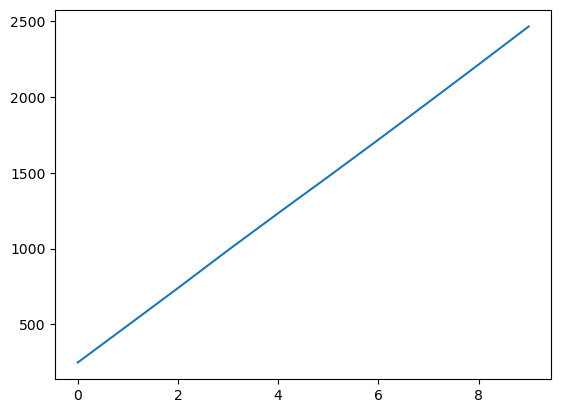

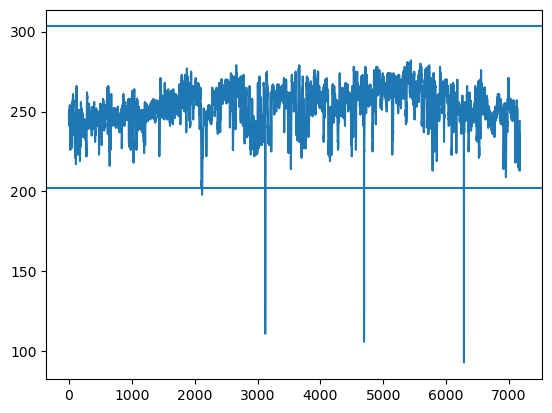

In [128]:
somma=B(RR_intervals[files[0]], 10)
plt.plot(somma)
#plt.plot(RR_intervals.iloc[:,0])
plt.show()
plt.plot(RR_intervals.iloc[:,0])
plt.axhline(np.mean(RR_intervals.iloc[:, 0])-4*np.std(RR_intervals.iloc[:,0]), 0, 1000)
plt.axhline(np.mean(RR_intervals.iloc[:, 0])+4*np.std(RR_intervals.iloc[:,0]), 0, 1000)

In [92]:
ann=wfdb.rdann(path+'f2y10', 'ecg')

(0.0, 10000.0)

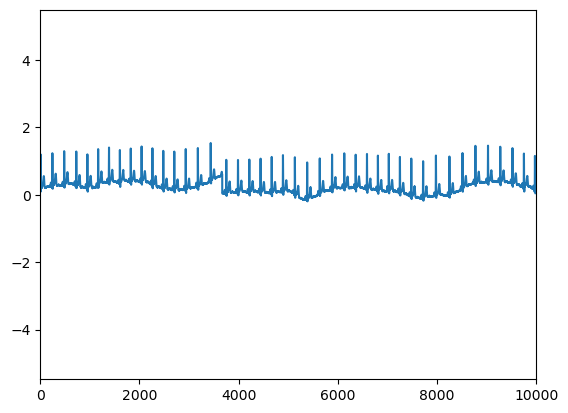

In [91]:
plt.plot(sig)
plt.xlim(0,10000)

In [ ]:
rr

array([[<AxesSubplot:title={'center':'f1o01'}>,
        <AxesSubplot:title={'center':'f1o02'}>,
        <AxesSubplot:title={'center':'f1o03'}>,
        <AxesSubplot:title={'center':'f1o04'}>,
        <AxesSubplot:title={'center':'f1o05'}>,
        <AxesSubplot:title={'center':'f1o06'}>],
       [<AxesSubplot:title={'center':'f1o07'}>,
        <AxesSubplot:title={'center':'f1o08'}>,
        <AxesSubplot:title={'center':'f1o09'}>,
        <AxesSubplot:title={'center':'f1o10'}>,
        <AxesSubplot:title={'center':'f1y01'}>,
        <AxesSubplot:title={'center':'f1y02'}>],
       [<AxesSubplot:title={'center':'f1y03'}>,
        <AxesSubplot:title={'center':'f1y04'}>,
        <AxesSubplot:title={'center':'f1y05'}>,
        <AxesSubplot:title={'center':'f1y06'}>,
        <AxesSubplot:title={'center':'f1y07'}>,
        <AxesSubplot:title={'center':'f1y08'}>],
       [<AxesSubplot:title={'center':'f1y09'}>,
        <AxesSubplot:title={'center':'f1y10'}>,
        <AxesSubplot:title={'center':

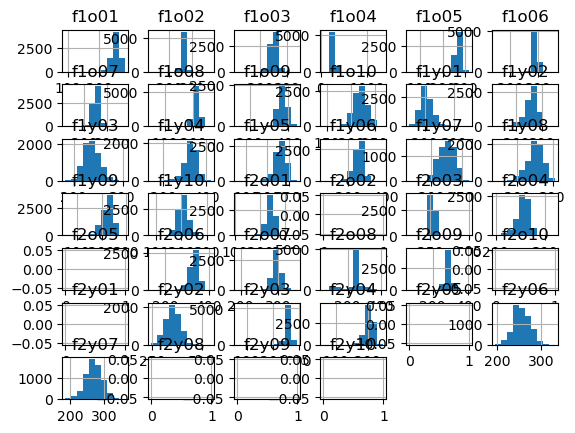

In [99]:

RR_intervals.hist()

<AxesSubplot:>

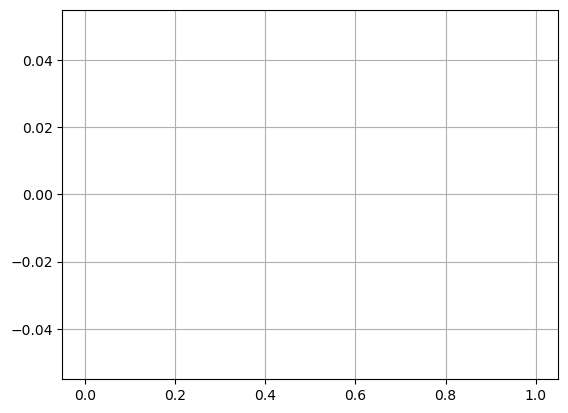

In [67]:
RR_intervals[files[-1]].hist()

<AxesSubplot:>

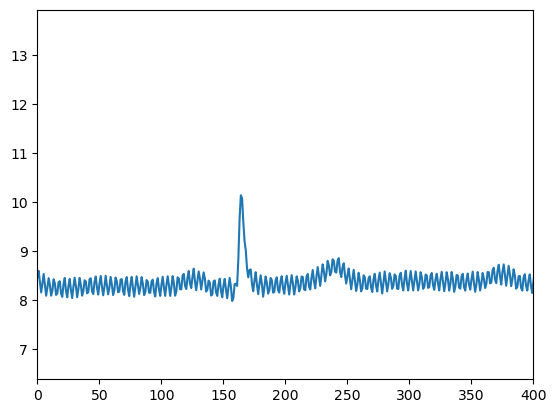

In [25]:
ECG_sig[files[0]].plot(xlim=(0,400))

In [17]:
ECG_sig.to_hdf('ECG_sig.hdf', key='ECG_sig')
ECG_sig.describe()

In [19]:
rr_dfs=[]
## Compute R peaks and RR sample distances
for file in files:
    xqrs = processing.XQRS(sig=ECG_sig[file], fs=250)
    xqrs.detect(verbose=False)
    rr=processing.calc_rr(xqrs.qrs_inds,fs=250)
    rr_dfs.append(pd.DataFrame({file: rr}))

    #rr=processing.calc_rr(xqrs.qrs_inds,fs=fields['fs'])
RR_intervals=pd.concat(rr_dfs, ignore_index=True, axis=1)
RR_intervals.columns=files


In [46]:
ECG_sig.iloc[:,0]

0          8.460
1          8.592
2          8.352
3          8.152
4          8.340
           ...  
2342523      NaN
2342524      NaN
2342525      NaN
2342526      NaN
2342527      NaN
Name: f1o01, Length: 2342528, dtype: float64

In [39]:
xqrs = processing.XQRS(sig=ECG_sig.iloc[files[0]], fs=250)
xqrs.detect(verbose=True)
print(xqrs.samples)
rr=processing.calc_rr(xqrs.qrs_inds,fs=250)
print(rr)
#rr_dfs.append(pd.DataFrame({file: rr}))

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.


AttributeError: 'XQRS' object has no attribute 'samples'

In [22]:
rr_dfs[0]

,f1o01


In [20]:
RR_intervals.to_hdf('RR_intervals.hdf', key='RR_intervals')
RR_intervals.describe()

,f1o01,f1o02,f1o03,f1o04,f1o05,f1o06,f1o07,f1o08,f1o09,f1o10,...,f2y01,f2y02,f2y03,f2y04,f2y05,f2y06,f2y07,f2y08,f2y09,f2y10
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,6573.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,356.337441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,36.454003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,247.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,332.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,356.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,381.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,549.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,f1o01,f1o02,f1o03,f1o04,f1o05,f1o06,f1o07,f1o08,f1o09,f1o10,...,f2y01,f2y02,f2y03,f2y04,f2y05,f2y06,f2y07,f2y08,f2y09,f2y10
count,1.812903e+06,1.811007e+06,1.813599e+06,1.811071e+06,1.558559e+06,1.819743e+06,1.809288e+06,1.802847e+06,1.810175e+06,1.813407e+06,...,1.768471e+06,2.342528e+06,1.758690e+06,1.763778e+06,1.755026e+06,1.755500e+06,1.754094e+06,1.807810e+06,1.801495e+06,1.793426e+06
mean,8.170863e+00,8.172382e+00,8.169827e+00,8.184010e+00,8.175195e+00,8.180925e+00,8.194527e+00,8.179436e+00,8.188422e+00,8.187674e+00,...,-2.550469e-02,-2.157191e-02,-3.912256e-02,-4.124496e-02,-2.419126e-02,-2.666709e-02,-3.403179e-02,-4.987821e-03,-9.386948e-02,-4.357979e-02
std,2.709484e-01,2.466914e-01,3.030455e-01,5.827494e-01,3.427048e-01,3.544442e-01,3.911568e-01,2.411337e-01,4.694781e-01,3.113712e-01,...,2.136751e-01,2.066910e-01,2.545058e-01,1.836620e-01,2.691529e-01,2.885463e-01,2.416139e-01,2.212406e-01,9.021183e-01,3.290430e-01
min,6.720000e+00,6.260000e+00,3.104000e+00,0.000000e+00,3.540000e+00,6.596000e+00,5.408000e+00,1.656000e+00,2.424000e+00,4.084000e+00,...,-4.995117e+00,-5.273438e-01,-1.625977e+00,-1.335449e+00,-4.992676e+00,-8.105469e-01,-1.555176e+00,-2.498779e+00,-1.249390e+01,-4.975586e+00
25%,8.036000e+00,8.064000e+00,8.076000e+00,7.932000e+00,8.000000e+00,7.980000e+00,8.028000e+00,8.048000e+00,8.060000e+00,8.008000e+00,...,-1.123047e-01,-1.037598e-01,-1.708984e-01,-1.391602e-01,-1.269531e-01,-1.440430e-01,-1.611328e-01,-9.521484e-02,-4.211426e-01,-1.440430e-01
50%,8.136000e+00,8.116000e+00,8.164000e+00,8.160000e+00,8.140000e+00,8.112000e+00,8.116000e+00,8.152000e+00,8.152000e+00,8.128000e+00,...,-6.835938e-02,-7.690430e-02,-1.098633e-01,-7.812500e-02,-4.882812e-02,-8.300781e-02,-7.568359e-02,-3.051758e-02,-2.807617e-01,-7.324219e-02
75%,8.236000e+00,8.212000e+00,8.276000e+00,8.380000e+00,8.284000e+00,8.264000e+00,8.236000e+00,8.264000e+00,8.288000e+00,8.272000e+00,...,0.000000e+00,-3.295898e-02,-1.953125e-02,9.765625e-03,4.638672e-02,-2.441406e-03,1.953125e-02,4.394531e-02,2.441406e-02,4.882812e-02
max,1.358400e+01,1.075600e+01,1.100400e+01,1.638000e+01,1.231200e+01,1.255200e+01,1.466000e+01,1.392000e+01,1.336800e+01,1.082400e+01,...,4.094238e+00,1.579590e+00,3.059082e+00,3.845215e+00,4.997559e+00,2.707520e+00,1.962891e+00,2.498779e+00,1.249390e+01,4.997559e+00


In [10]:
len(sig_list

SyntaxError: unexpected EOF while parsing (3708787473.py, line 1)

In [ ]:
print(np.shape(sig))

In [ ]:
plt.plot(output[0][:,0], label='breath signal')
plt.plot(output[0][:,1], label='ecg signal')
plt.xlim(0,800)
plt.legend()
plt.show()

In [35]:
sig, fields = wfdb.rdsamp('physionet.org/files/fantasia/1.0.0/f1o01', channels=[1])
print(sig[:,0])
xqrs = processing.XQRS(sig=sig[:,0], fs=fields['fs'])
xqrs.detect()

[8.46  8.592 8.352 ... 8.172 7.892 7.94 ]
Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


In [36]:
xqrs.qrs_inds

array([    165,     414,     659, ..., 1812238, 1812472, 1812716])

In [ ]:
output[0][:,1]

In [ ]:
#%matplotlib widget
plt.plot(output[0][:,1], label='ecg signal')
plt.scatter(xqrs.qrs_inds, output[0][:,1][xqrs.qrs_inds], color='r')
#plt.xlim(0, 1200)

In [ ]:
wfdb.plot_items(signal=sig, ann_samp=[xqrs.qrs_inds])
#plt.xlim(0,400)
#plt.show()

In [ ]:
ann_ref = wfdb.rdann('physionet.org/files/fantasia/1.0.0/f1o01', 'ecg')

In [ ]:
wfdb.plot_items(signal=sig, ann_samp=[ann_ref.sample])


In [ ]:
comparitor = processing.compare_annotations(ann_ref.sample[1:],
                                                xqrs.qrs_inds,
                                                int(0.01 * fields['fs']),
                                                sig[:,0])
comparitor.print_summary()
comparitor.plot()

In [37]:
rr=processing.calc_rr(xqrs.qrs_inds,fs=fields['fs'])

In [38]:
rr

array([249, 245, 246, ..., 222, 234, 244])

In [ ]:
rr_file=processing.ann2rr('physionet.org/files/fantasia/1.0.0/f1o01', 'ecg')
rr_file

In [ ]:
rr_file.shape, rr.shape

In [ ]:
plt.hist(rr/250, bins=int(np.sqrt(len(rr))), label='ns', density=True)
plt.hist(rr_file/250, bins=int(np.sqrt(len(rr))), label='file', density=True, alpha=0.5)
plt.legend()
#plt.xlim(0.8, 1.2)
plt.show()

In [ ]:
np.mean(rr), np.std(rr)

In [ ]:
np.mean(rr_file), np.std(rr_file)